In [ ]:
import numpy as np

date = "mother_folder"
dl_folder = f"base_path/{date}_DL"

dl_number = "project_name"

look_frame = 30
models = 5

In [ ]:
import tqdm
import os

shap_vals = []
bases = []
first_positives = []
for n in tqdm.tqdm(range(5)):
    model_dir = os.path.join(os.path.join(dl_folder, f"model_{dl_number}"), f"model_{n}")

    shap_val = np.load((f"{model_dir}/{date}_{dl_number}_shap_val.npy"))
    base     = np.load((f"{model_dir}/{date}_{dl_number}_shap_base.npy"))

    print(shap_val.shape)

    shap_vals.append(shap_val)
    bases.append(base)

    first_positive = np.load(f"{model_dir}/{date}_{dl_number}_valid_1st_positive_frames.npy")
    first_positives.append(first_positive)

bases     = np.array(bases)

print(len(shap_vals), bases.shape)
print(len(first_positives), first_positives[0].shape, first_positives[1].shape, first_positives[2].shape)

100%|██████████| 5/5 [00:00<00:00, 25.84it/s]


(210, 31, 10)
(210, 31, 10)
(240, 31, 10)
(300, 31, 10)
(300, 31, 10)
5 (5,)
5 (7,) (7,) (8,)


In [3]:
valid_ex = []
for n in range(len(first_positives)):
    temp_ex = []
    for f in range(first_positives[n].shape[0]):
        temp_ex.append(first_positives[n][f]//80)
    valid_ex.append(np.array(temp_ex))

print(len(valid_ex), valid_ex[0].shape, valid_ex[1].shape, valid_ex[2].shape)

5 (7,) (7,) (8,)


In [4]:
first_shaps = []
mean_shaps = []
for n in tqdm.tqdm(range(len(first_positives))):
    first_shap = shap_vals[n][first_positives[n]]
    first_shaps.append(first_shap)

    mean_shap = np.mean(first_shap, axis=0)
    mean_shaps.append(mean_shap)

mean_shaps = np.array(mean_shaps)

print(len(first_shaps), first_shaps[0].shape, first_shaps[1].shape, first_shaps[2].shape)
print(mean_shaps.shape)

100%|██████████| 5/5 [00:00<00:00, 4983.73it/s]

5 (7, 31, 10) (7, 31, 10) (8, 31, 10)
(5, 31, 10)


In [ ]:
# set time frames

fs = 20

# start time
start_value = -1.5

# increase per frames
increment = 1/fs

# frames
count = look_frame+1

t = [start_value + i * increment for i in range(count)]

In [6]:
roi_number = []
for ic in range(mean_shaps.shape[2]):
    roi_number.append(f"IC{ic+1}")

print(roi_number)

['IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC6', 'IC7', 'IC8', 'IC9', 'IC10']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_shap_mean(shap_val):
    s = np.mean(shap_val, axis=0).reshape([look_frame+1, shap_val.shape[2]])
    plt.figure(figsize=(4, 4))
    sns.heatmap(s.transpose(),cmap='bwr', vmin=-0.02, vmax=0.02)
    #sns.heatmap(s.transpose(),cmap='bwr')

    ticks = np.arange(0.5, look_frame + 1.0, 10)
    labels = np.linspace(start_value, 0, len(ticks))
    plt.xticks(ticks, labels, rotation=0)
    plt.yticks( np.arange(0.5, shap_val.shape[2]+0.5), roi_number, rotation=0)
    plt.axvspan(30.45, 30.55, color='black', alpha=1)
    plt.title("SHAP values")
    plt.xlabel("Time (sec)")
    plt.ylabel("IC #")
    plt.show()

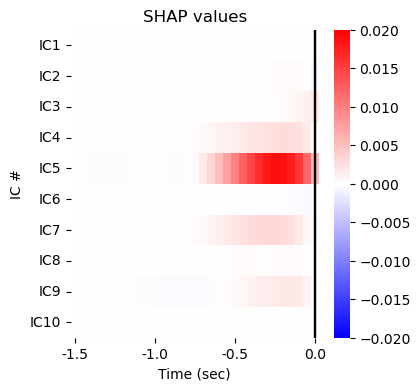

In [10]:
show_shap_mean(np.mean(mean_shaps, axis=0).reshape(1, mean_shaps.shape[1], mean_shaps.shape[2]))

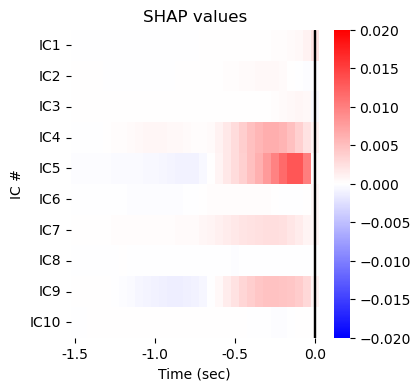

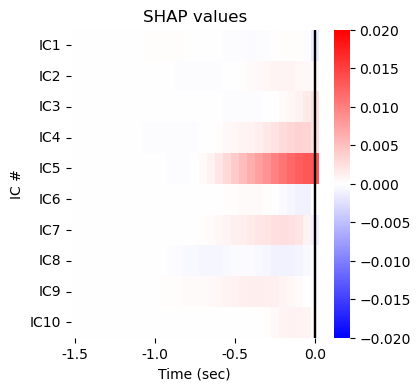

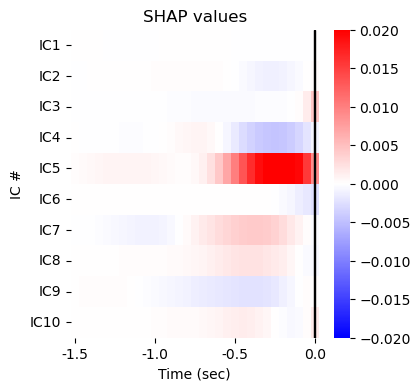

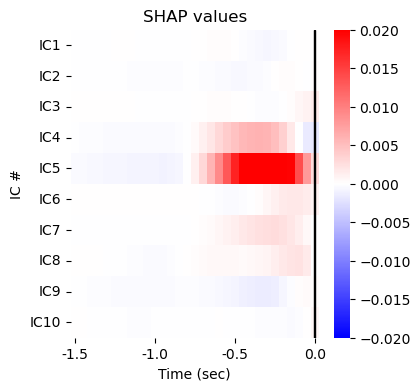

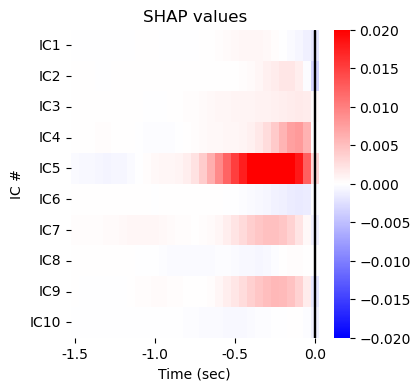

In [11]:
for model in range(mean_shaps.shape[0]):
    show_shap_mean(mean_shaps[model].reshape(1, mean_shaps.shape[1], mean_shaps.shape[2]))

In [43]:
np.save(f"{dl_folder}/model_{dl_number}/{date}_{dl_number}_mean_shap_ic.npy", mean_shaps)

In [12]:
from wfield import *

def my_reconstruct(u,svt,dims = None):
    '''
    Reconstruct a decomposed signal (e.g. decomposed with SVD for example).

    Can also reconstruct sparse arrays, use dims when reconstructing sparse.

    Usage:
        res = reconstruct(u,svt,dims = None)
    
    Joao Couto - wfield, 2020
    '''
    if issparse(u):
        if dims is None:
            raise ValueError('Supply dims = [H,W] when using sparse arrays')
    else:
        if dims is None:
            dims = u.shape[:2]
            
    return np.matmul(u, svt).reshape((*dims,-1)).transpose(-1,0,1).squeeze()

In [ ]:
U = np.load("ica-der/ic_image_extracted.npy")
print(U.shape)

(10, 256, 270)


In [14]:
U = U.transpose(1, 2, 0)
print(U.shape)

(256, 270, 10)


In [ ]:
use_comp = first_shaps[0].shape[2]

mov_array = []
for model in range(len(first_shaps)):
    mov = []
    for ex in range(first_shaps[model].shape[0]):
        temp_mov = my_reconstruct(U[:, :,:use_comp], first_shaps[model][ex].transpose())
        mov.append(temp_mov)
    mov_array.append(np.array(mov))

print(len(mov_array), mov_array[0].shape, mov_array[1].shape, mov_array[2].shape)

5 (7, 31, 256, 270) (7, 31, 256, 270) (8, 31, 256, 270)


In [16]:
ave_mov = []
for model in range(len(mov_array)):
    temp_ave = np.mean(mov_array[model], axis=0)
    ave_mov.append(temp_ave)

ave_mov = np.array(ave_mov)
print(ave_mov.shape)

(5, 31, 256, 270)


In [17]:
np.save(f"{dl_folder}/model_{dl_number}/{date}_{dl_number}_allen_image_shap.npy", ave_mov)

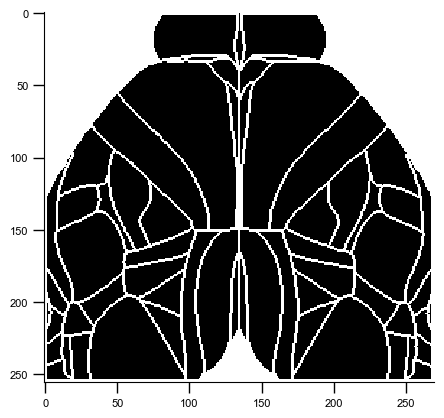

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

atlas_map = np.load("region_border_mask_path")
plt.imshow(atlas_map, cmap='grey')

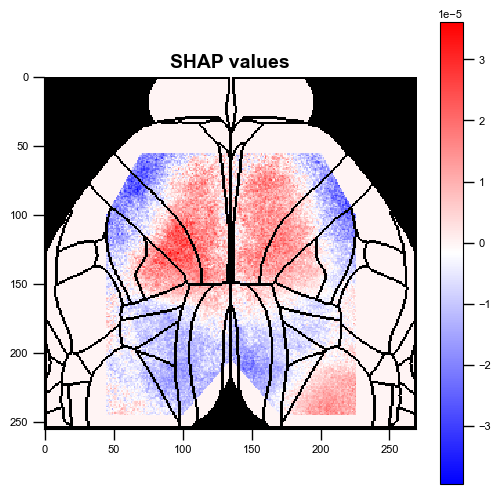

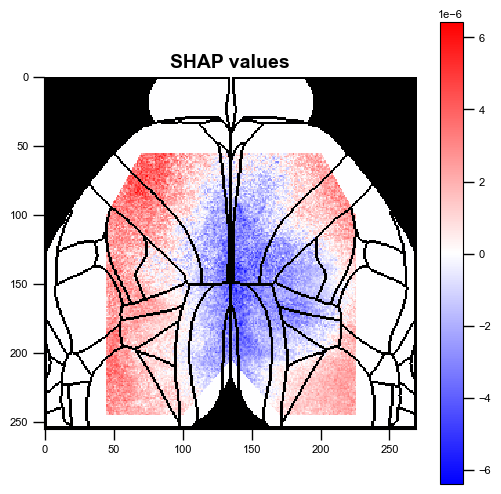

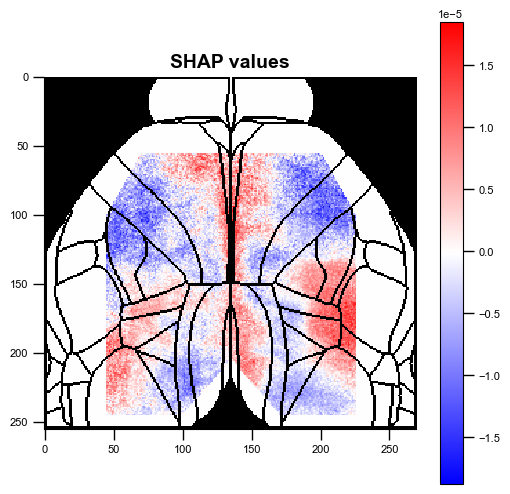

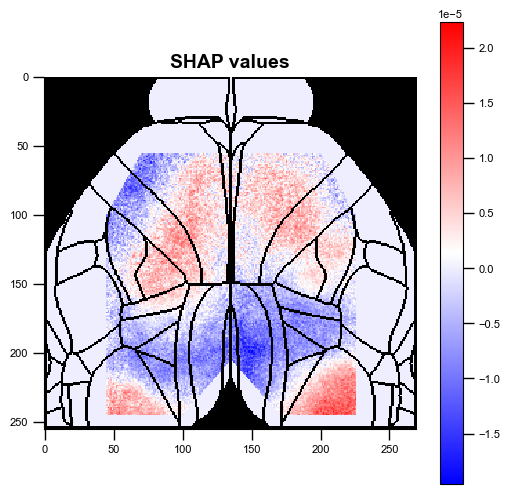

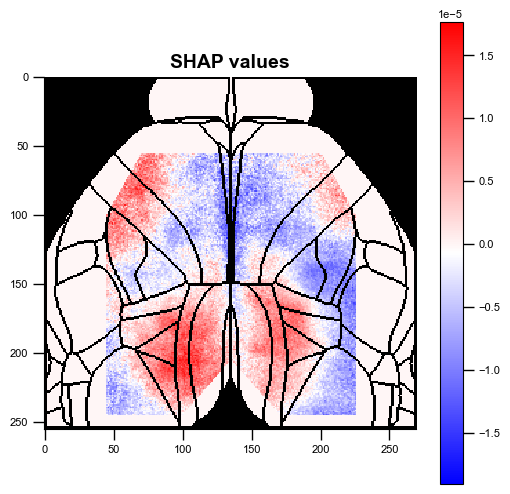

In [ ]:
import matplotlib.pyplot as plt

for model in range(ave_mov.shape[0]):
    plt.figure(figsize=(6, 6))
    mask = atlas_map
    masked = np.ma.masked_where(mask == 1, np.mean(ave_mov[model, 10:14], axis=0))
    cmap = plt.cm.bwr.copy()
    cmap.set_bad(color='black') 
    plt.imshow(masked, cmap=cmap)
    plt.colorbar()
    plt.title("SHAP values")
    plt.show()

In [ ]:
vmin, vmax=-0.0002, +0.0002

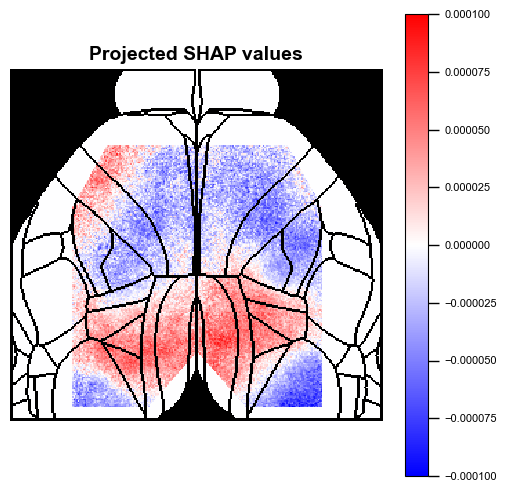

In [ ]:
import matplotlib.pyplot as plt

common_shap = np.mean(ave_mov, axis=0)
plt.figure(figsize=(6, 6))
mask = atlas_map
masked = np.ma.masked_where(mask == 1, np.mean(common_shap, axis=0))
cmap = plt.cm.bwr.copy()
cmap.set_bad(color='black')  
plt.imshow(masked, cmap=cmap, vmin=-0.0001, vmax=+0.0001)
plt.colorbar()
plt.title("Projected SHAP values")
plt.axis('off')
plt.show()

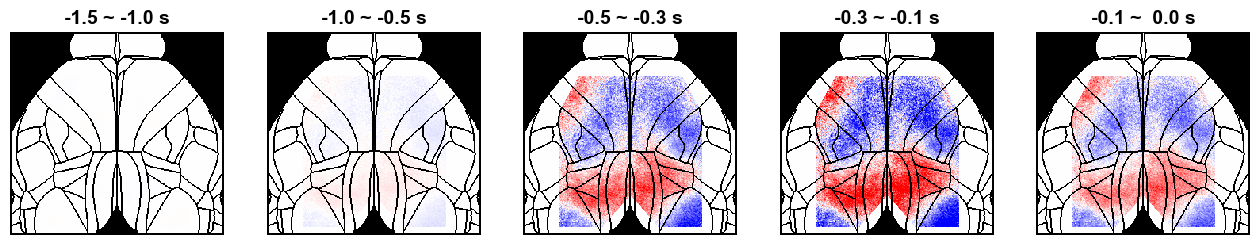

In [ ]:
import matplotlib.pyplot as plt

common_shap = np.mean(ave_mov, axis=0)
shap_map = [
            np.mean(common_shap[0:10], axis=0),
            np.mean(common_shap[10:20], axis=0),
            np.mean(common_shap[20:24], axis=0),
            np.mean(common_shap[24:28], axis=0),
            np.mean(common_shap[28:], axis=0),
            ]

time_list = [
            "-1.5 ~ -1.0 s",
            "-1.0 ~ -0.5 s",
            "-0.5 ~ -0.3 s",
            "-0.3 ~ -0.1 s",
            "-0.1 ~  0.0 s",
            ]


plt.figure(figsize=(16, 4))
mask = atlas_map
for shapmap in range(len(shap_map)):
    plt.subplot(1, 5, shapmap+1)
    masked = np.ma.masked_where(mask == 1, shap_map[shapmap])
    cmap = plt.cm.bwr.copy()
    cmap.set_bad(color='black') 
    plt.title(time_list[shapmap])
    plt.imshow(masked, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')

plt.show()

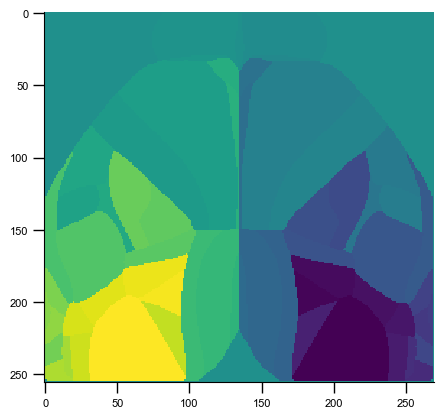

In [ ]:
atlas = np.load("atlas-path").astype(int)
plt.imshow(atlas)

In [ ]:
# make traces for each brain region

import tqdm

# ROIs applied to atlas
unique_values = np.unique(atlas)
roi_means = []
roi_positions = []

for val in tqdm.tqdm(unique_values):
    mask = (atlas == val)  
        y_indices, x_indices = np.where(mask)
        center_x, center_y = int(np.mean(x_indices)), int(np.mean(y_indices))
        roi_positions.append((center_x, center_y, val)) 
        temp_roi_means = []
        for ex in range(len(ave_mov)):
            temp_mov = ave_mov[ex]
            mean_values = np.mean(temp_mov[:, mask], axis=1)   # average time course in ROIs
            temp_roi_means.append(mean_values)
        roi_means.append(temp_roi_means)




# (ROIs, frames)
roi_means_array = np.array(roi_means)

100%|██████████| 61/61 [00:00<00:00, 479.04it/s]


In [71]:
print(roi_means_array.shape)

(61, 5, 31)


In [72]:
roi_means_array = roi_means_array.reshape(roi_means_array.shape[0], roi_means_array.shape[1]*roi_means_array.shape[2])
print(roi_means_array.shape)

(61, 155)


In [ ]:
indices_to_left = [-33,-32,-31,-27,-18,-17,-16,-12,-11,-10,-9,-4,-3,
                   3,4,9,10,11,12,16,17,18,27,31,32,33]
index_left = [index for index, value in enumerate(unique_values.tolist()) if value in indices_to_left]

print(index_left)
print(len(indices_to_left)) 

[0, 1, 2, 6, 13, 14, 15, 18, 19, 20, 21, 26, 27, 33, 34, 39, 40, 41, 42, 45, 46, 47, 54, 58, 59, 60]
26


In [74]:
roi_numbers = []
roi_traces = []
for j, i in enumerate(index_left):
    roi_numbers.append(unique_values[i])
    roi_traces.append(roi_means_array[i])

roi_numbers = np.array(roi_numbers)
roi_traces = np.array(roi_traces)

print(roi_numbers)
print(roi_numbers.shape)
print(roi_traces.shape)

[-33 -32 -31 -27 -18 -17 -16 -12 -11 -10  -9  -4  -3   3   4   9  10  11
  12  16  17  18  27  31  32  33]
(26,)
(26, 155)


In [75]:
roi_traces = roi_traces.reshape(roi_traces.shape[0], ave_mov.shape[0], int(roi_traces.shape[1]/ave_mov.shape[0]))
print(roi_traces.shape)

(26, 5, 31)


In [ ]:
roi_names = np.array([' VISp_R  ', ' VISam_R ', ' VISa_R  ', ' VISpm_R ',
                 'SSp-ul_R ', 'SSp-ll_R ', 'SSp-tr_R ',
                 'RSPagl_R ', ' RSPd_R  ', ' RSPv_R  ',
                 ' ACAd_R  ',
                 '  MOs_R  ', '  MOp_R  ',
                 '  MOp_L  ', '  MOs_L  ',
                 ' ACAd_L  ',
                 ' RSPv_L  ', ' RSPd_L  ', 'RSPagl_L ',
                 'SSp-tr_L ', 'SSp-ll_L ', 'SSp-ul_L ',
                 ' VISpm_L ', ' VISa_L  ', ' VISam_L ', ' VISp_L  '
                 ])

print(roi_names.shape)

(26,)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_shap_roi_mean(roi_array, roi_names):
    s = np.mean(roi_array, axis=1)
    plt.figure(figsize=(4, 4))
    #sns.heatmap(s, cmap='bwr', vmin=-2e-5, vmax=2e-5)
    sns.heatmap(s, cmap='bwr')
    ticks = np.arange(0.5, look_frame + 1.0, 10)
    labels = np.linspace(start_value, 0, len(ticks))
    plt.xticks(ticks, labels)
    plt.yticks( np.arange(0.5, roi_array.shape[0]+0.5), roi_names, rotation=0)
    plt.axvspan(30.45, 30.55, color='black', alpha=1)
    plt.title("Projected SHAP values")
    plt.xlabel("Time (s)")
    plt.show()

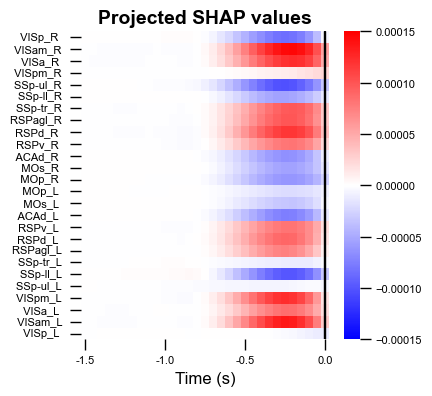

In [84]:
show_shap_roi_mean(roi_traces, roi_names)

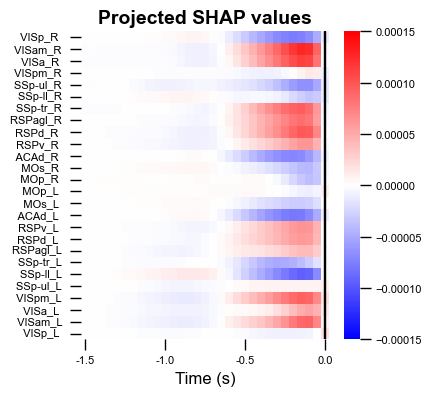

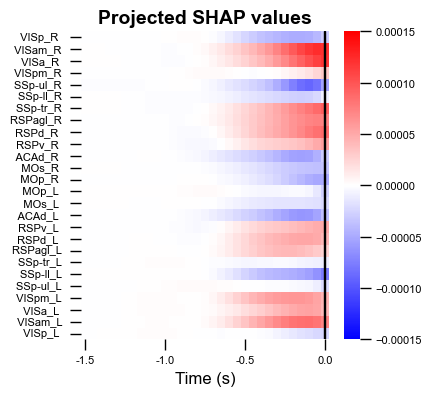

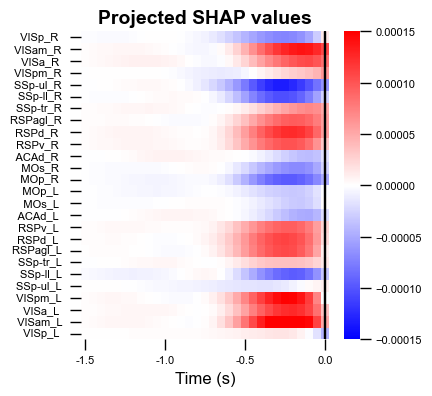

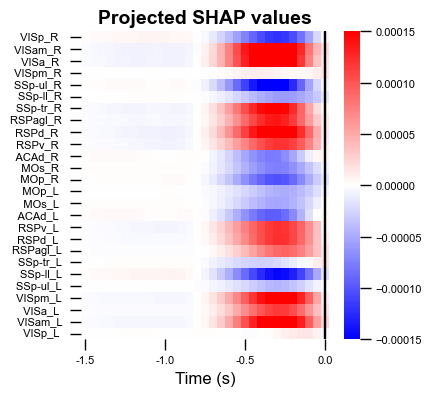

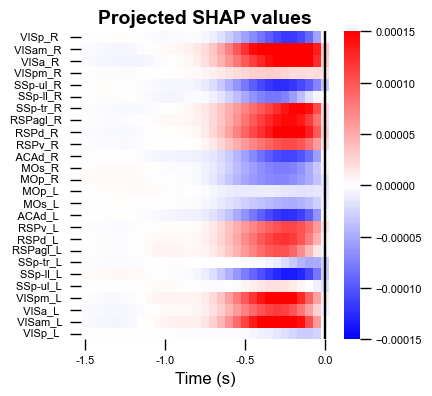

In [85]:
for model in range(roi_traces.shape[1]):
    show_shap_roi_mean(roi_traces[:, model].reshape(roi_traces.shape[0], 1, roi_traces.shape[2]), roi_names)

In [86]:
np.save(f"{dl_folder}/model_{dl_number}/{date}_{dl_number}_mean_shap_allen.npy", roi_traces.transpose(1, 2, 0))